# Wildfire Prediction with Logistic Regression


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


## Load the Data


In [4]:
train_df = pd.read_csv("wildfires_training.csv")
test_df = pd.read_csv("wildfires_test.csv")

print(train_df)
print(test_df)

    fire  year  temp  humidity  rainfall  drought_code  buildup_index  day  \
0     no  2015    28        59       0.0          8.06           3.47    1   
1     no  2010    30        61       1.3          8.17           4.03    2   
2     no  2009    26        83      13.1          8.08           3.59    3   
3     no  2017    25        87       2.5          7.18           2.42    4   
4     no  2014    28        77       0.0         14.98           4.63    5   
..   ...   ...   ...       ...       ...           ...            ...  ...   
149  yes  2017    31        67       0.0         45.15          17.89   26   
150   no  2017    29        89       4.4          8.74           6.52   27   
151   no  2009    27        88       0.5          8.87           3.71   28   
152   no  2016    25        56       0.1         15.54           6.10   29   
153   no  2012    24        62       0.2         16.72           5.75   30   

     month  wind_speed  
0        6          19  
1        6   

## Preprocess the Data


In [5]:
X_train = train_df.drop("fire", axis=1)
Y_train = train_df["fire"]

X_test = test_df.drop("fire", axis=1)
Y_test = test_df["fire"]


## Encode labels

In [6]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_test = encoder.transform(Y_test)

## Define model and train



In [7]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train,Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
model_accuracy  = accuracy_score(Y_test, log_model.predict(X_test))

print("The Accuracy of simple logistic regression without hyperparameter:", model_accuracy)

The Accuracy of simple logistic regression without hyperparameter: 0.9


In [9]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Parameter grid for hyperparameter tuning

In [10]:
max_iters = [100, 500, 1000, 2500, 5000]  
C_values = np.logspace(-2, 4, 1000)



## Apply best Hyperparameter to Log regression

In [11]:
best_score = -1
best_params = {}

for C in C_values:
    for max_iter in max_iters:
        try:
            model = LogisticRegression(C=C, max_iter=max_iter)  # penalty='l2' and solver='lbfgs' by default
            model.fit(X_train_scaled, Y_train)
            score = accuracy_score(Y_test, model.predict(X_test_scaled))
            
            if score > best_score:
                best_score = score
                best_params = {
                    "C": C,
                    "max_iter": max_iter
                }
        except Exception:
            # skip convergence or other errors
            continue

print("Best hyperparameters found:", best_params)
print("Best Accuracy on Test Set:", best_score)

Best hyperparameters found: {'C': np.float64(14.831025143361044), 'max_iter': 100}
Best Accuracy on Test Set: 0.9


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load data
train = pd.read_csv("wildfires_training.csv")
test = pd.read_csv("wildfires_test.csv")

# Prepare features and labels
X_train = train.drop(columns=["fire"])
y_train = train["fire"].map({"yes": 1, "no": 0})

X_test = test.drop(columns=["fire"])
y_test = test["fire"].map({"yes": 1, "no": 0})

# --- Baseline Model ---
print("Baseline Model")
model = RandomForestClassifier(random_state=1234)
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

# --- Manual Grid Search ---
print("\nHyperparameter Tuning for Random Forest")
results = []

for n_estimators in [10, 50, 100, 200]:
    for max_depth in [None, 5, 10, 20, 50]:
        for min_samples_leaf in [1, 5, 10, 20 ]:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                random_state=1234
            )
            rf.fit(X_train_scaled, y_train)
            y_pred = rf.predict(X_test_scaled)
            test_acc = accuracy_score(y_test, y_pred)
            results.append({
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_leaf": min_samples_leaf,
                "test_acc": test_acc
            })

# Convert to DataFrame and show results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("test_acc", ascending=False)

print("\nTop 5 Results:")
print(results_df.head())

print("\nBest Parameters:")
best = results_df.iloc[0]
print(f"n_estimators: {best['n_estimators']}")
print(f"max_depth: {best['max_depth']}")
print(f"min_samples_leaf: {best['min_samples_leaf']}")
print(f"test_acc: {best['test_acc']:.4f}")

# --- Train final model with best parameters ---
final_model = RandomForestClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']) if pd.notna(best['max_depth']) else None,
    min_samples_leaf=int(best['min_samples_leaf']),
    random_state=1234
)
final_model.fit(X_train_scaled, y_train)
y_pred_final = final_model.predict(X_test_scaled)

Baseline Model
Train accuracy: 1.0000
Test accuracy:  0.8200

Hyperparameter Tuning for Random Forest

Top 5 Results:
    n_estimators  max_depth  min_samples_leaf  test_acc
60           200        NaN                 1      0.88
76           200       50.0                 1      0.88
68           200       10.0                 1      0.88
72           200       20.0                 1      0.88
28            50       10.0                 1      0.86

Best Parameters:
n_estimators: 200.0
max_depth: nan
min_samples_leaf: 1.0
test_acc: 0.8800


Baseline Logistic Regression
Train accuracy: 0.8961
Test accuracy:  0.8600

Grid Search 

Top 10 Results
1. Penalty: l2  , C:    5000, Train: 0.9221, Test: 0.9000
2. Penalty: l2  , C:   10000, Train: 0.9221, Test: 0.9000
3. Penalty: none, C:     1.0, Train: 0.9286, Test: 0.9000
4. Penalty: l2  , C:     100, Train: 0.9221, Test: 0.8800
5. Penalty: l2  , C:     200, Train: 0.9286, Test: 0.8800

Best Hyperparameters
Penalty: l2
C: 5000
Train accuracy: 0.9221
Test accuracy: 0.9000


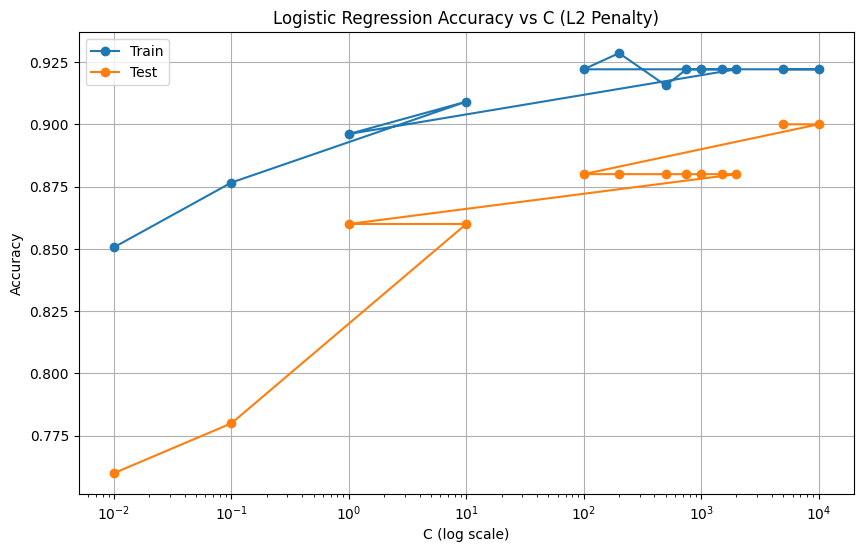

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# File paths
TRAINING_FILE = "wildfires_training.csv"
TEST_FILE = "wildfires_test.csv"

# Load data
train = pd.read_csv(TRAINING_FILE)
test = pd.read_csv(TEST_FILE)

# Separate features and labels
X_train = train.drop(columns=["fire"])
y_train = train["fire"].map({"yes": 1, "no": 0})

X_test = test.drop(columns=["fire"])
y_test = test["fire"].map({"yes": 1, "no": 0})

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Baseline model
print("Baseline Logistic Regression")
baseline = LogisticRegression(max_iter=1000, random_state=42)
baseline.fit(X_train, y_train)

train_acc = accuracy_score(y_train, baseline.predict(X_train))
test_acc = accuracy_score(y_test, baseline.predict(X_test))

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

# Manual grid search
C_values = [0.01, 0.1, 1, 10, 100, 200, 500, 750, 1000, 1500, 2000, 5000, 10000]
penalties = ["l2", None]

results = []
best_test_acc = 0
best_params = {}

for penalty in penalties:
    if penalty is None:
        C_list = [1.0]
    else:
        C_list = C_values
    
    for C in C_list:
        model = LogisticRegression(penalty=penalty, C=C, max_iter=2000, random_state=42)
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        pen_name = penalty if penalty else "none"
        results.append((pen_name, C, train_acc, test_acc))
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_params = {
                "penalty": pen_name,
                "C": C,
                "train_acc": train_acc,
                "test_acc": test_acc
            }

results.sort(key=lambda x: x[3], reverse=True)

print("\nTop 10 Results")
for i, (pen, C, tr_acc, te_acc) in enumerate(results[:5], 1):
    print(f"{i}. Penalty: {pen:4s}, C: {C:7}, Train: {tr_acc:.4f}, Test: {te_acc:.4f}")

print("\nBest Hyperparameters")
print(f"Penalty: {best_params['penalty']}")
print(f"C: {best_params['C']}")
print(f"Train accuracy: {best_params['train_acc']:.4f}")
print(f"Test accuracy: {best_params['test_acc']:.4f}")

l2_results = [r for r in results if r[0] == "l2"]
Cs = [r[1] for r in l2_results]
train_accs = [r[2] for r in l2_results]
test_accs = [r[3] for r in l2_results]

plt.figure(figsize=(10, 6))
plt.plot(Cs, train_accs, marker="o", label="Train")
plt.plot(Cs, test_accs, marker="o", label="Test")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs C (L2 Penalty)")
plt.legend()
plt.grid(True)
plt.show()



